# SQL, NoSQL, Big Data y todo lo demás

![bohio](https://www.iesbohio.es/web/images/ies/logobohioreducido.png)

Charla a los alumnos del IES El Bohio, 17 de noviembre de 2022.

## BohioControls !!!

### Una empresa de control domótico de edificios

![bohiocontrols](images/bohiocontrols.jpg)

In [ ]:
%load utils/functions.py

In [ ]:
from IPython.display import Image
from pprint import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import json

%matplotlib inline
try:
    matplotlib.style.use('seaborn-v0_8')
except:
    matplotlib.style.use('seaborn-white')

In [ ]:
wooclap("(SQL)")

In [ ]:
wooclap('(NoSQL)')

In [ ]:
wooclap('(JSON)')

In [ ]:
yoda(u"Para alcanzar la fuerza NoSQL debes conocer")

### Imaginemos

Imaginemos que queremos realizar la sensorización (domótica) de un edificio.

![sensor1](images/sensor_kawaii1_small.PNG)
![sensor1](images/sensor_kawaii2_small.PNG)

![sensor_room](images/room_sensors.jpeg)

In [ ]:
say(u"Formato de sensor de temperatura/humedad")

In [ ]:
sayM(json.dumps({ "id" : 2, "type" : "temp/humidity_v1", "temp" : 25, "humidity": 40},indent=3), align='left')

In [ ]:
say(u"Formato de sensor de presencia")

In [ ]:
sayM(json.dumps({ "id" : 23, "type" : "presence_v1", "person_detected" : True},indent=3), align='left')

In [ ]:
say(u"Formato de sensor de luz")

In [ ]:
sayM(json.dumps({ "id" : 11, "type" : "light_sensor_v1", "light_level" : 10},indent=3), align='left')

In [ ]:
say(u"Vamos a probar con SQL...")

In [ ]:
%pip install ipython-sql

In [ ]:
%load_ext sql

Una base de datos en memoria... Para probar

In [ ]:
%env DATABASE_URL=sqlite://?cache=shared

In [ ]:
say(u'¿Cómo diseño el esquema?')

In [ ]:
%%sql
DROP TABLE IF EXISTS Buildings;
CREATE TABLE Buildings
(
    id   INTEGER,
    name TEXT,
    PRIMARY KEY(id)
);

In [ ]:
%%sql
DROP TABLE IF EXISTS Rooms;
CREATE TABLE Rooms
(
    id   INTEGER,
    name TEXT,
    building_id INTEGER,
    FOREIGN KEY(building_id) REFERENCES Buildings(id)
);

In [ ]:
%%sql
DROP TABLE IF EXISTS Sensors;
CREATE TABLE Sensors
(
    id   INTEGER,
    type TEXT,
    PRIMARY KEY(id)
);

In [ ]:
%%sql
DROP TABLE IF EXISTS SensorsInRooms;
CREATE TABLE SensorsInRooms
(
    room_id INTEGER,
    sensor_id INTEGER,
    FOREIGN KEY(room_id) REFERENCES Rooms(id),
    FOREIGN KEY(sensor_id) REFERENCES Sensors(id),
    PRIMARY KEY(room_id, sensor_id)
);

In [ ]:
%%sql
DROP TABLE IF EXISTS Readings;
CREATE TABLE Readings
(
    id        INTEGER,
    timestamp INTEGER,
    sensor_id INTEGER,
    type      STRING,
    -- datos de sensores
    PRIMARY KEY(id),
    FOREIGN KEY(sensor_id) REFERENCES Sensors(id)
);

In [ ]:
sayM(
'''CREATE TABLE Readings
(
    id        INTEGER,
    timestamp INTEGER,
    sensor_id INTEGER,
    type      STRING,
    -- datos de sensores
    PRIMARY KEY(id)
);''')

In [ ]:
%%capture
# Añado los sensores!

# Primero los de temperatura/humedad, 10 sensores, IDs 0 al 9
for i in range(0,10):
    %sql INSERT INTO Sensors VALUES (:i, "temp/humidity_v1")
    
# Sensores de luz, 10 sensores, IDs 10 al 19
for i in range(10,20):
    %sql INSERT INTO Sensors VALUES (:i, "light_sensor_v1")

# Sensores de presencia, 10 sensores, IDs 20 al 29
for i in range(20,30):
    %sql INSERT INTO Sensors VALUES (:i, "presence_v1")

In [ ]:
%%sql
select * from Sensors;

In [ ]:
%%sql
DROP TABLE IF EXISTS Readings;
CREATE TABLE Readings
(
    id          INTEGER,
    timestamp   INTEGER,
    sensor_id   INTEGER,
    type        STRING,
    -- temp sensor
    temp        REAL,
    humidity    REAL,
    -- light_sensor
    light_level REAL,
    -- presence sensor
    person_detected INTEGER,
    PRIMARY KEY(id),
    FOREIGN KEY(sensor_id) REFERENCES Sensors(id)
);

In [ ]:
say(u'Insertamos algunas lecturas...')

In [ ]:
%%capture
import time
import datetime
import random

for i in range(0,100):
    now = datetime.datetime.now()
    unix_timestamp = int(datetime.datetime.timestamp(now)*1000)
    sensor_id = int(random.randrange(0,10))
    temp = random.randrange(20,29)
    humidity = random.randrange(40,80)
    %sql INSERT INTO Readings VALUES (:i, :unix_timestamp, :sensor_id, "temp/humidity_v1", :temp, :humidity , NULL, NULL);

for i in range(100,200):
    now = datetime.datetime.now()
    unix_timestamp = int(datetime.datetime.timestamp(now)*1000)
    sensor_id = int(random.randrange(10,20))
    light_level = random.randrange(0,100)
    %sql INSERT INTO Readings VALUES (:i, :unix_timestamp, :sensor_id, "light_sensor_v1", NULL, NULL, :light_level, NULL);

for i in range(200,300):
    now = datetime.datetime.now()
    unix_timestamp = int(datetime.datetime.timestamp(now)*1000)
    sensor_id = int(random.randrange(20,30))
    person_detected = 1 if random.random() >= 0.5 else 0
    %sql INSERT INTO Readings VALUES (:i, :unix_timestamp, :sensor_id, "presence_v1", NULL, NULL, NULL, :person_detected);

In [ ]:
%%sql
select * from Readings

In [ ]:
say("Añado 5 habitaciones...")

In [ ]:
%%capture
# Añado 1 edificio y 5 habitaciones

%sql INSERT INTO Buildings VALUES(1, "Edificio Principal")

for i in range(0,5):
    hab = "Habitación %d" % (i)
    %sql INSERT INTO Rooms VALUES (:i, :hab, 1)

In [ ]:
%%sql 
select * from Rooms

In [ ]:
say(u"Mapeo de sensores a habitaciones...")

In [ ]:
%%capture

for i in range(0,5):
    for sensor in [0,5,10,15,20,25]:
        sensor_final = i + sensor
        %sql INSERT INTO SensorsInRooms VALUES (:i, :sensor_final)

In [ ]:
%%sql
select * from SensorsInRooms;

In [ ]:
say(u"Lecturas por habitaciones... (habitación 1)")

In [ ]:
%%sql
select * 
from Readings r JOIN SensorsInRooms sir ON r.sensor_id = sir.sensor_id
WHERE sir.room_id == 1

In [ ]:
say(u"Empiezan los problemas...")

In [ ]:
say(u"Formato de sensor de temperatura/humedad, V2!!!!")

In [ ]:
sayM(json.dumps({ "id" : 2, "type" : "temp/humidity_v2", "temp" : 25, "humidity": 40, "air_quality": 2},indent=3))

In [ ]:
say(u"NoSQL")

In [ ]:
say(u"NoSQL:\n¡Mira mamá! ¡No SQL!")

In [ ]:
say(u"NoSQL:\nSchemaless!")

In [ ]:
say(u"NoSQL:\nFree/Open Source!")

In [ ]:
say(u"NoSQL:\n¡Escalabilidad!")

In [ ]:
say(u"NoSQL:\n¡Estructuras de datos complejas!")

In [ ]:
say(u"NoSQL — Cuatro tipos:\n - Clave/valor\n - Documentos\n - Columnares\n - Grafos", align="left")

In [ ]:
Image("images/nosql-history.png")

# MongoDB (documentos)

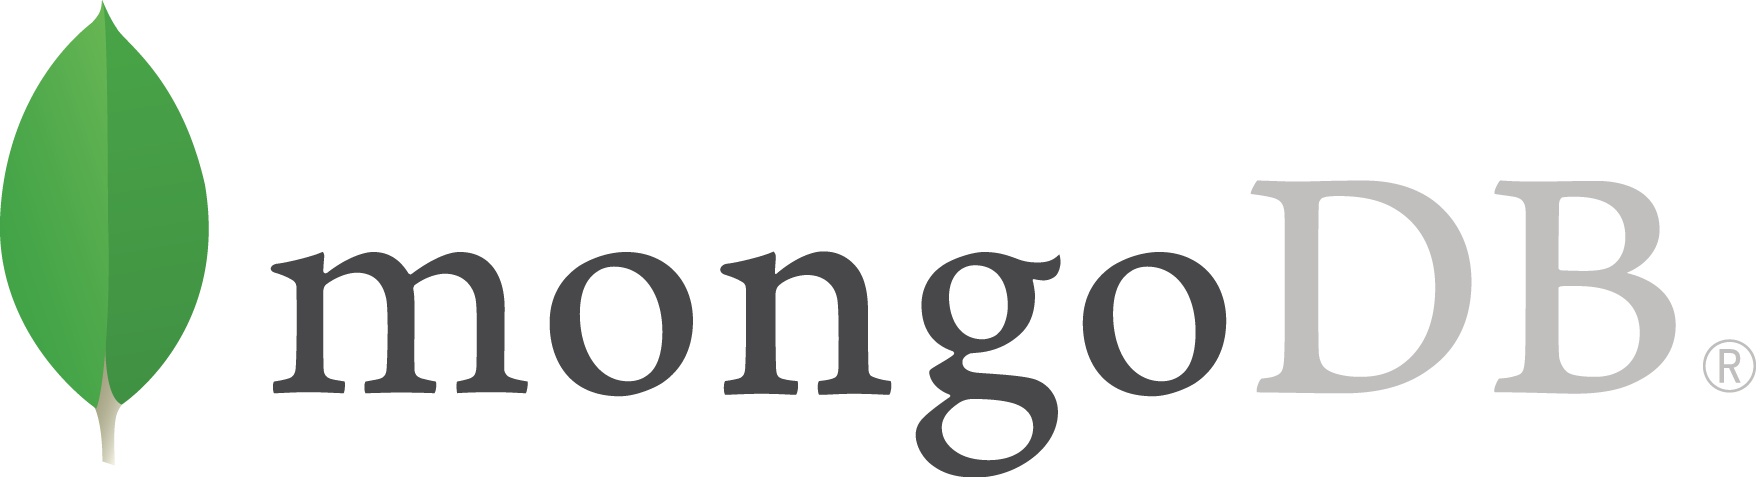

Base de datos documental que usaremos como ejemplo. Una de las más extendidas:

- Modelo de documentos JSON (BSON, en binario, usado para eficiencia)
- Map-Reduce para transformaciones de la base de datos y consultas
- Lenguaje propio de manipulación de la base de datos llamado "de agregación" (aggregate)
- Soporta sharding (distribución de partes de la BD en distintos nodos)
- Soporta replicación (copias sincronizadas master-slave en distintos nodos)
- No soporta ACID
- La transacción se realiza a nivel de **DOCUMENTO**

In [ ]:
%pip install pymongo

In [ ]:
import pymongo
import codecs

from pymongo import MongoClient
passw = codecs.encode('ObuvbPbagebyf22', 'rot_13')
client = MongoClient("mongodb://root:%s@neuromancer.inf.um.es" % (passw), 27000)
client

In [ ]:
say(u'¡¡¡Vamos a añadir valores de los sensores!!!')

In [ ]:
sayM(u"http://neuromancer.inf.um.es:5000")

http://neuromancer.inf.um.es:5000/

![selectsensor](images/select_sensor.png)

![temp_sensor](images/temp_sensor.png)

Accedemos a la base de datos `bohiocontrols`:

In [ ]:
db = client.bohiocontrols

Y la colección `readings`:

In [ ]:
readings = db.readings

In [ ]:
list(readings.find({},limit=20))

In [ ]:
say(u'¿Qué pasa con "temp/humidity_v2"?')

In [ ]:
import datetime
now = datetime.datetime.now()
unix_timestamp = int(datetime.datetime.timestamp(now)*1000)
readings.insert_one({'sensor_id': 30, 
                     "timestamp": unix_timestamp, 
                     "type" : "temp/humidity_v2",
                     "temp" : 25,
                     "humidity": 40,
                     "air_quality": 2})

In [ ]:
readings.find_one({'sensor_id': 30})

In [ ]:
client.list_database_names()

In [ ]:
all_temp_readings = list(readings.find({'type' : 'temp/humidity_v1'}))

In [ ]:
df = pd.DataFrame.from_dict(all_temp_readings)

In [ ]:
from datetime import datetime
df['timestamp'] = [datetime.fromtimestamp(x/1000) for x in df['timestamp']]

In [ ]:
df.index = df.timestamp

In [ ]:
df

In [ ]:
df.temp.plot()

In [ ]:
df.temp.plot(kind='bar')

In [ ]:
df.humidity.plot()

In [ ]:
say(u"Habitaciones con sensores en el caso de MongoDB")

In [ ]:
for i in range(0,5):
    db.rooms.insert_one({"id": i,
                         "name": "Habitación %d" % (i),
                         "building_id" : 1,
                         "sensors" : [r for r in range(i, 30, 5)]})

In [ ]:
import pprint
sayM(pprint.pformat(db.rooms.find_one(),indent=2))

In [ ]:
say(u'Los sensores se pueden añadir como una lista\n[0, 5, 10, 15, 20, 25]')

In [ ]:
say(u'Pero imaginemos que queremos saber el último valor de cada sensor\n(Lo más rápido posible)')

In [ ]:
%%sql
select * from Readings WHERE sensor_id = 1 ORDER BY timestamp DESC LIMIT 1;

In [ ]:
say(u'Requiere del uso de una búsqueda por la tabla.\nSe puede usar un índice, pero...')

In [ ]:
%pip install redis[hiredis]

In [ ]:
img_to_fixed_width_html_image("https://redis.com/wp-content/themes/wpx/assets/images/logo-redis.svg")

In [ ]:
import redis
r = redis.Redis(host='neuromancer.inf.um.es', port=6300, db=0)

In [ ]:
import datetime
now = datetime.datetime.now()
unix_timestamp = int(datetime.datetime.timestamp(now)*1000)
last_reading_s1 = {
    'sensor_id': 1,
    "timestamp": unix_timestamp, 
    "type" : "temp/humidity_v1",
    "temp" : 25,
    "humidity": 40
}
r.set('sensor_id_1', pprint.pformat(last_reading_s1,indent=2))
print(r.get('sensor_id_1').decode('utf-8'))

In [ ]:
say(r.get('sensor_id_2').decode('utf-8'),align='left')

In [ ]:
sayM('''
sensor_data = {
    "sensor_id" : id,
    "timestamp" : int(datetime.datetime.timestamp(datetime.datetime.now())*1000),
    "type" : "temp/humidity_v1",
    "temp" : form.temp.data,
    "humidity": form.humidity.data
}

readings.insert_one(sensor_data) # MongoDB

redis.set("sensor_id_%s" % (id), pprint.pformat(sensor_data,indent=2)) # Redis
''',align='left')

In [ ]:
say(u'Es súper rápido, especializado. Se usa para, por ejemplo:\n - Guardar iconos\n - Perfiles de usuario\n - Valores pequeños de acceso rápido\n - etc.', align='left')

In [ ]:
say(u'Persistencia políglota: Uso de varias BBDD especializadas')

In [ ]:
say(' '*100 + u'ESCALABILIDAD'+ ' '*100)

In [ ]:
say(' '*50 + u'ESCALABILIDAD'+ ' '*50)

In [ ]:
say(' '*20 + u'ESCALABILIDAD'+ ' '*20)

In [ ]:
say(u'  ESCALABILIBILIBILIDAD  ')

![sensor_room](images/room_sensors.jpeg)

![sensor_room](images/100rooms.jpeg)

![sensor_room](images/10000rooms.jpeg)

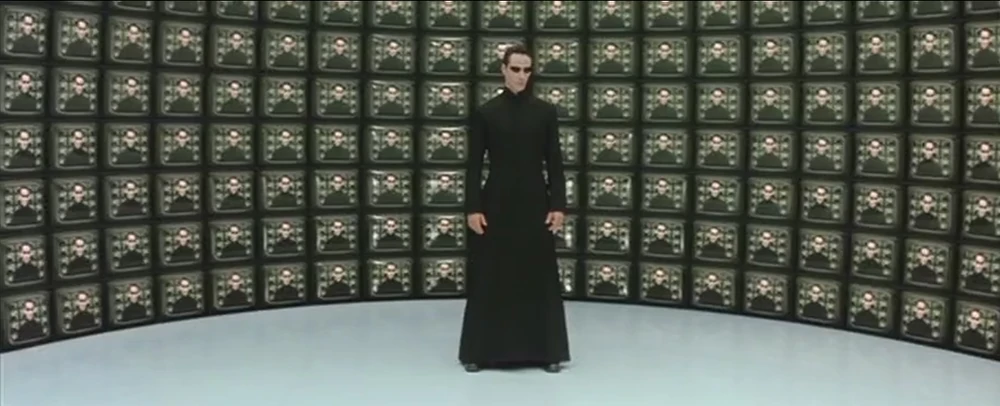


In [ ]:
say(u'Big Data!')

![internet_one_minute](https://www.visualcapitalist.com/wp-content/uploads/2021/11/data-never-sleeps-9-1.0-1200px-1.png)

![internet_one_minute](images/data_volume_flight.png)

In [ ]:
say('¡¡1 TB por vuelo en 2017!!')

In [ ]:
say(u'En 2017 hubo 101.000 vuelos por día')

In [ ]:
yoda(u'Más o menos 101.000 TB POR DÍA de datos')

In [ ]:
yoda(u'May the force be with you')

In [ ]:
chew('Grrrrrrrrrr!')